# Machine Learning & Statistics Project

# Introduction

We have been tasked with creating a web service that uses machine learning to make predictions based on the data set provided on power production taken from Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. We must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. Below is a breakdown of the data and a description of the modelling methods used to determine the correct algorithm for to accurately model the power production on any given wind speed.

## Wind Power Description

Wind power is a form of renewable energy that generates electrical power through the turning of a turbine in an electrical generator with the use of the force provided by the wind.Wind is an intermittent energy source

# Explore the data

First we will import the required libraries and start to explore the data to get a feel for what we're dealing with.

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import sklearn  
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from collections import Counter

#matplotlib inline
rcParams['figure.figsize']=5, 4

# Import the csv file containing the information
df = pd.read_csv('powerproduction.txt')

# Check first 10 rows to ensure we're getting correct data in as first 5 columns power outputt displayed as 0
print(f'{df.head(11)}\n')
print(f'{df.tail(15)}\n')

# Display dataframes information
print(f'{df.info()}\n')
print(f'{df.describe()}\n')
print(f'{df.shape}\n')

print(f'{df.isnull().sum()}\n')
print(f'{df.isna().sum()}')

    speed  power
0   0.000  0.000
1   0.125  0.000
2   0.150  0.000
3   0.225  0.000
4   0.275  0.000
5   0.325  4.331
6   0.400  5.186
7   0.450  3.826
8   0.501  1.048
9   0.526  5.553
10  0.551  6.498

      speed    power
485  24.249  103.700
486  24.299   93.694
487  24.349   93.078
488  24.374   98.223
489  24.399   95.117
490  24.499    0.000
491  24.525    0.000
492  24.575    0.000
493  24.650    0.000
494  24.750    0.000
495  24.775    0.000
496  24.850    0.000
497  24.875    0.000
498  24.950    0.000
499  25.000    0.000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB
None

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6

From the above we can see that the information received is 2 colmuns of 500 rows populated by floats. The speed range is 0-25 and the power range  is 0-100. No units are given in this table but for the purpose of this project it will be assumed the speed is measured in m/s and the power is in % of design output.

We can see that at the minimum and maximum speed values there is a value of 0 which is showing us a minimum wind speed required to start  the power generation and a high point cut off switch. We will need to visualise the data to check for anymore 0 values scattered in the data as this could potentially throw off our calculations.

The data is sorted sequentially by speed power with the power generation generally increasing with it within a certain range. This shows an almost linear relationship between the two variables.

There appears to be no missing information in the data as shown by our `df.isnull().sum()` and `df.isna().sum()` check. This data will need to be cleaned before it will be useable. Too determine if there are any other  anomolies we'll plot some graphs to give a better visual representation off the data.

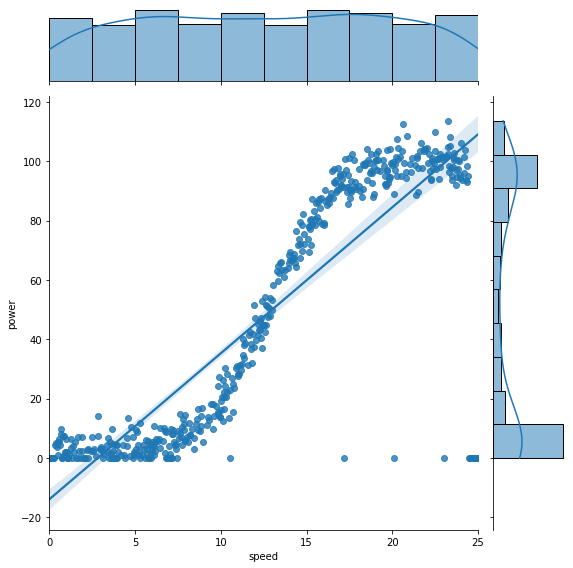

In [72]:
# Visualise dataset
sns.jointplot(data=df, x="speed", y="power",kind="reg", height=8)
#sns.relplot(data=df, x="speed", y="power", height=8, aspect=2)

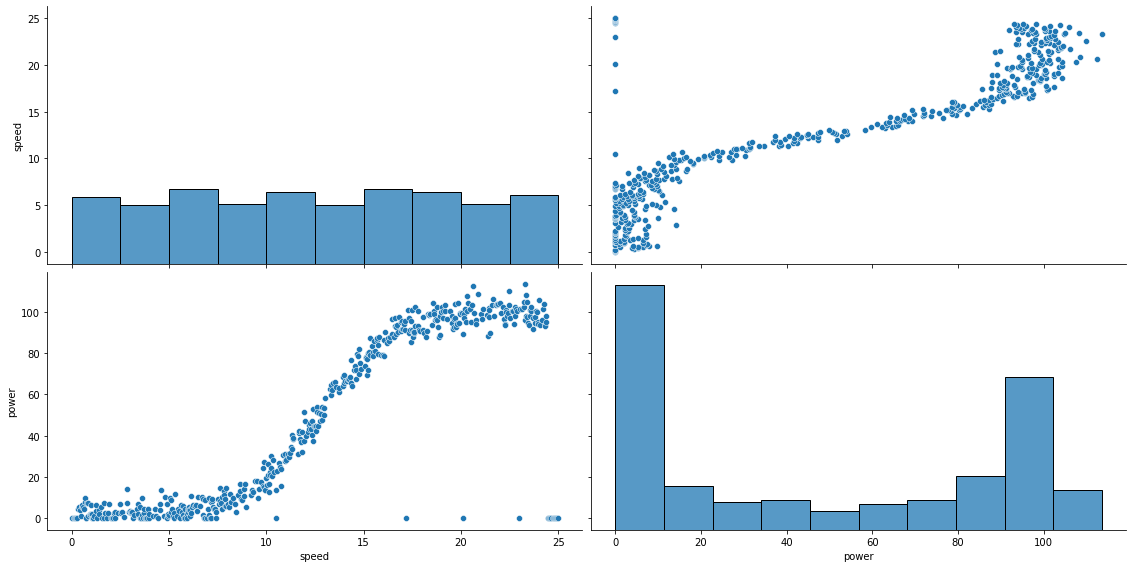

In [73]:
sns.pairplot(df, height=4, aspect=2);

The above shows us  that it is not a typical linear relationship between speed  and power. It appears to follow a polynomial pattern. It shows that while the wind speed is below 10 m/s th epower generation remains low. From 10 to around 18 m/s there is a much faster growth of power generation before peaking out around the 100% mark at about 18  m/s wind speed where it remains until the wind speed reaches 24.5 m/s when an automatic cut off takes effect dropping power generation to 0.

We can also see that there are several 0 values taken for the power generation at various speeds. This could be due to a malfunction or maintenance period on the turbine itself so these will need to be removed before moving forward to determine an accurate algorithm. 

##  Clean Data

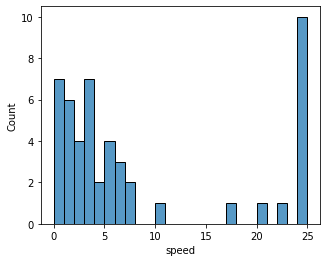

In [74]:
#  Check were majority of readings for 0 power generation values are located. 
df_check= df[df['power'] == 0]

sns.histplot(data=df_check, x="speed", bins=25);


It appears the vast majority of the 0 readings are at both the low and high ends. From our inital look at the head and tail of the data we can see that the power generation doesn't start until 0.325 m/s wind speed and cuts out from 24.499 m/s wind speed. We will now  use this infomration to remove all values of 0 above the 0.325 value assuming that this is due to a malfunction or a maintenance period and therefore should not have any influence on our alogrithm generation as it is an independent event that has no bearing on the data. The high end cut off also needs to be removed to ensure accuracy in our prerdictions.

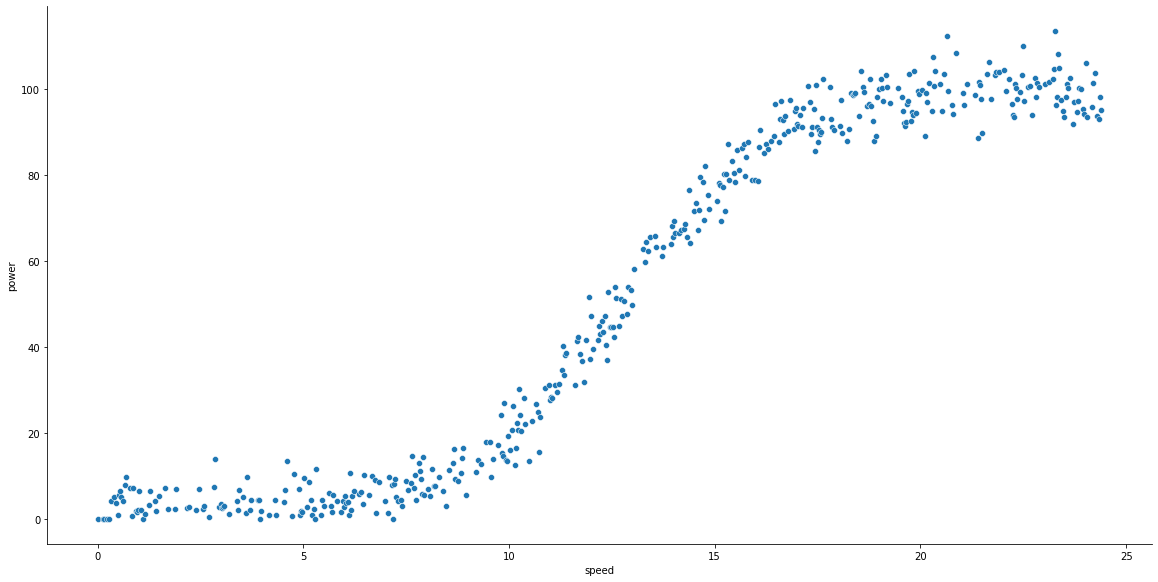

In [75]:
# https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
df = df.drop(df[(df.speed >= 0.325) & (df.power == 0.0)].index)

sns.relplot(data=df, x="speed", y="power", height=8, aspect=2)

(456, 2)

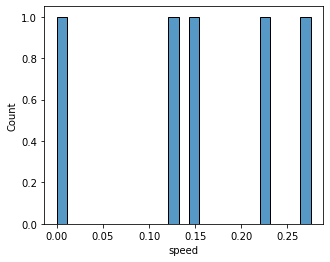

In [76]:
# Check dataframe for locations of remaining 0 values
df_check= df[df['power'] == 0]

sns.histplot(data=df_check, x="speed", bins=25);

df.shape

We can see form  the above that all 0 values above 0.325 m/s have been removed as intended. This brings our dataframe size from 500 rows to 456 rows for a total of 46 rows removed. We can now work with this dataframe to begin to determine the correct algorithm.

## Linear Regression



Looking at the graphs provided we will explore the possibility of fitting a linear regression line onn to the graph. I believe this will not lead to an accurate predictor model but afterwards we can look at polynomial lines to make the fit more suitable.

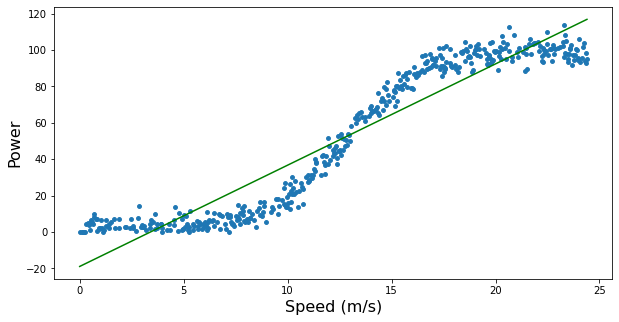

Root mean squared error for Linear Regression is 12.971479727702798
The R2 value is 0.8980963337957819


In [77]:
# https://www.analyticsvidhya.com/blog/2020/03/polynomial-regression-python/v
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

y = df.power.to_numpy() 
x = df.speed.to_numpy().reshape(-1, 1)

# Training Model
lm=LinearRegression()
lm.fit(x.reshape(-1,1),y.reshape(-1,1))

y_pred=lm.predict(x.reshape(-1,1))

# plotting predictions
plt.figure(figsize=(10,5))
plt.scatter(x,y,s=15)
plt.plot(x,y_pred,color='g')
plt.xlabel('Speed (m/s)',fontsize=16)
plt.ylabel('Power',fontsize=16)
plt.show()
print(f'Root mean squared error for Linear Regression is {np.sqrt(mean_squared_error(y,y_pred))}')
print(f'The R2 value is {r2_score(y, y_pred)}')

***

# Polynomial Regression

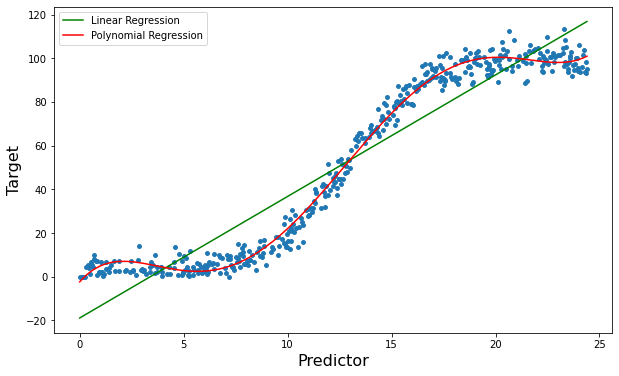

Root mean squared error for Polynomial Regression=> 4.4159978346386435
The R2 value is 0.9881894949408745


In [78]:
from sklearn.pipeline import Pipeline

# creating pipeline and fitting it on data
Input=[('polynomial',PolynomialFeatures(degree=5)),('modal',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(x.reshape(-1,1),y.reshape(-1,1))

poly_pred=pipe.predict(x.reshape(-1,1))
#sorting predicted values with respect to predictor
sorted_zip = sorted(zip(x,poly_pred))
x_poly, poly_pred = zip(*sorted_zip)
#plotting predictions
plt.figure(figsize=(10,6))
plt.scatter(x,y,s=15)
plt.plot(x,y_pred,color='g',label='Linear Regression')
plt.plot(x_poly,poly_pred,color='r',label='Polynomial Regression')
plt.xlabel('Predictor',fontsize=16)
plt.ylabel('Target',fontsize=16)
plt.legend()
plt.show()

print(f'Root mean squared error for Polynomial Regression=> {np.sqrt(mean_squared_error(y,poly_pred))}')
print(f'The R2 value is {r2_score(y, poly_pred)}')

In [79]:
# Test refers to the wind power entered to provide a predicted value. Emp refers to the empirical data from csv file received
test1, emp1 = df.at[12,'speed'], df.at[12,'power']
test2, emp2 = df.at[97,'speed'] , df.at[97,'power'] 
test3, emp3 = df.at[201,'speed'], df.at[201,'power']
test4, emp4 = df.at[251,'speed'], df.at[251,'power']
test5, emp5 = df.at[293,'speed'], df.at[293,'power']
test6, emp6 = df.at[357,'speed'], df.at[357,'power']
test7, emp7 = df.at[425,'speed'], df.at[425,'power'] 

# Function ot give a positive percentage difference value
def AccuracyL (test, emp):
    if (((lm.predict([[test]]))/emp)*100 < 100):
        return f"Undershot by {100 - ((lm.predict([[test]]))/emp)*100}%"
    else:
        return f"Overshot by {(((lm.predict([[test]]))/emp) * 100) - 100}%"

def AccuracyP (test, emp):
    if ((pipe.predict([[test]])/emp)*100 < 100):
        return f"Undershot by {100 - (pipe.predict([[test]])/emp)*100}%"
    else:
        return f"Overshot by {((pipe.predict([[test]])/emp) * 100) - 100}%"

    
print(f'\nTest 1 (Linear)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {(lm.predict([[test1]]))}\nActual Difference: {abs(emp1-lm.predict([[test1]]))}\nAccuracy: {AccuracyL (test1, emp1)}')
print(f'\nTest 1 (Polynomial)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {pipe.predict([[test1]])}\nActual Difference: {abs(emp1-pipe.predict([[test1]]))}\nAccuracy: {AccuracyP (test1, emp1)}')
print(f'\nTest 2 (Linear)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {(lm.predict([[test2]]))}\nActual Difference: {abs(emp2-lm.predict([[test2]]))}\nAccuracy: {AccuracyL (test2, emp2)}')
print(f'\nTest 2 (Polynomial)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {pipe.predict([[test2]])}\nActual Difference: {abs(emp2-pipe.predict([[test2]]))}\nAccuracy: {AccuracyP (test2, emp2)}')
print(f'\nTest 3 (Linear)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {(lm.predict([[test3]]))}\nActual Difference: {abs(emp3-lm.predict([[test3]]))}\nAccuracy: {AccuracyL (test3, emp3)}')
print(f'\nTest 3 (Polynomial)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {pipe.predict([[test3]])}\nActual Difference: {abs(emp3-pipe.predict([[test3]]))}\nAccuracy: {AccuracyP (test3, emp3)}')
print(f'\nTest 4 (Linear)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {(lm.predict([[test4]]))}\nActual Difference: {abs(emp4-lm.predict([[test4]]))}\nAccuracy: {AccuracyL (test4, emp4)}')
print(f'\nTest 4 (Polynomial)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {pipe.predict([[test4]])}\nActual Difference: {abs(emp4-pipe.predict([[test4]]))}\nAccuracy: {AccuracyP (test4, emp4)}')
print(f'\nTest 5 (Linear)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {(lm.predict([[test5]]))}\nActual Difference: {abs(emp5-lm.predict([[test5]]))}\nAccuracy: {AccuracyL (test5, emp5)}')
print(f'\nTest 5 (Polynomial)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {pipe.predict([[test5]])}\nActual Difference: {abs(emp5-pipe.predict([[test5]]))}\nAccuracy: {AccuracyP (test5, emp5)}')
print(f'\nTest 6 (Linear)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {(lm.predict([[test6]]))}\nActual Difference: {abs(emp6-lm.predict([[test6]]))}\nAccuracy: {AccuracyL (test6, emp6)}')
print(f'\nTest 6 (Polynomial)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {pipe.predict([[test6]])}\nActual Difference: {abs(emp6-pipe.predict([[test6]]))}\nAccuracy: {AccuracyP (test6, emp6)}')
print(f'\nTest 7 (Linear)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {(lm.predict([[test7]]))}\nActual Difference: {abs(emp7-lm.predict([[test7]]))}\nAccuracy: {AccuracyL (test7, emp7)}')
print(f'\nTest 7 (Polynomial)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {pipe.predict([[test7]])}\nActual Difference: {abs(emp7-pipe.predict([[test7]]))}\nAccuracy: {AccuracyP (test7, emp7)}')


Test 1 (Linear)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[-15.43706284]]
Actual Difference: [[19.65706284]]
Accuracy: Undershot by [[465.80717639]]%

Test 1 (Polynomial)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[2.95460264]]
Actual Difference: [[1.26539736]]
Accuracy: Undershot by [[29.98571954]]%

Test 2 (Linear)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[9.89978675]]
Actual Difference: [[5.37478675]]
Accuracy: Overshot by [[118.77981761]]%

Test 2 (Polynomial)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[2.62959469]]
Actual Difference: [[1.89540531]]
Accuracy: Undershot by [[41.88741012]]%

Test 3 (Linear)-
Wind Speed: 10.21 m/s
Empirical data: 20.704
Predicted  value: [[37.88493243]]
Actual Difference: [[17.18093243]]
Accuracy: Overshot by [[82.98363809]]%

Test 3 (Polynomial)-
Wind Speed: 10.21 m/s
Empirical data: 20.704
Predicted  value: [[23.90135325]]
Actual Difference: [[3.19735325]]
Accuracy: 

***

## Neural Networks

In [80]:
import tensorflow.keras as kr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('powerproduction.txt')
df = df.drop(df[(df.speed >= 0.325) & (df.power == 0.0)].index)

poly = df

test = df

# Train a different model.
model = kr.models.Sequential()
model.add(kr.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

# Fit the data.
model.fit(poly['speed'], poly['power'], epochs=500, batch_size=10)

Epoch 1/500
46/46 [==============================] - 1s 510us/step - loss: 4380.1618
Epoch 2/500
46/46 [==============================] - 0s 820us/step - loss: 4339.4919
Epoch 3/500
46/46 [==============================] - 0s 687us/step - loss: 3991.7983
Epoch 4/500
46/46 [==============================] - 0s 709us/step - loss: 3672.5875
Epoch 5/500
46/46 [==============================] - 0s 687us/step - loss: 3382.7787
Epoch 6/500
46/46 [==============================] - 0s 687us/step - loss: 3173.4376
Epoch 7/500
46/46 [==============================] - 0s 665us/step - loss: 3157.7639
Epoch 8/500
46/46 [==============================] - 0s 665us/step - loss: 2914.7371
Epoch 9/500
46/46 [==============================] - 0s 687us/step - loss: 2893.5801
Epoch 10/500
46/46 [==============================] - 0s 842us/step - loss: 2803.2215
Epoch 11/500
46/46 [==============================] - 0s 997us/step - loss: 2614.5317
Epoch 12/500
46/46 [==============================] - 0s 864us/

46/46 [==============================] - 0s 798us/step - loss: 97.1922
Epoch 98/500
46/46 [==============================] - 0s 842us/step - loss: 95.9167
Epoch 99/500
46/46 [==============================] - 0s 842us/step - loss: 92.6848
Epoch 100/500
46/46 [==============================] - 0s 1ms/step - loss: 94.1672
Epoch 101/500
46/46 [==============================] - 0s 1ms/step - loss: 91.2875
Epoch 102/500
46/46 [==============================] - 0s 909us/step - loss: 88.9359
Epoch 103/500
46/46 [==============================] - 0s 1ms/step - loss: 80.5963
Epoch 104/500
46/46 [==============================] - 0s 798us/step - loss: 80.9348
Epoch 105/500
46/46 [==============================] - 0s 754us/step - loss: 81.1829
Epoch 106/500
46/46 [==============================] - 0s 997us/step - loss: 78.0564
Epoch 107/500
46/46 [==============================] - 0s 1ms/step - loss: 78.2613
Epoch 108/500
46/46 [==============================] - 0s 909us/step - loss: 80.0210
Epoc

46/46 [==============================] - 0s 1ms/step - loss: 44.3531
Epoch 195/500
46/46 [==============================] - 0s 1ms/step - loss: 40.2912
Epoch 196/500
46/46 [==============================] - 0s 1ms/step - loss: 43.7447
Epoch 197/500
46/46 [==============================] - 0s 963us/step - loss: 44.3729
Epoch 198/500
46/46 [==============================] - 0s 798us/step - loss: 47.0221
Epoch 199/500
46/46 [==============================] - 0s 775us/step - loss: 42.3577
Epoch 200/500
46/46 [==============================] - 0s 897us/step - loss: 40.4749
Epoch 201/500
46/46 [==============================] - 0s 1ms/step - loss: 45.8812
Epoch 202/500
46/46 [==============================] - 0s 1ms/step - loss: 42.3916
Epoch 203/500
46/46 [==============================] - 0s 1ms/step - loss: 43.8704
Epoch 204/500
46/46 [==============================] - 0s 923us/step - loss: 38.6964
Epoch 205/500
46/46 [==============================] - 0s 972us/step - loss: 41.6705
Epoch 

46/46 [==============================] - 0s 766us/step - loss: 21.9473
Epoch 292/500
46/46 [==============================] - 0s 817us/step - loss: 25.8322
Epoch 293/500
46/46 [==============================] - 0s 797us/step - loss: 21.9990
Epoch 294/500
46/46 [==============================] - 0s 758us/step - loss: 25.3443
Epoch 295/500
46/46 [==============================] - 0s 740us/step - loss: 22.2177
Epoch 296/500
46/46 [==============================] - 0s 824us/step - loss: 24.5734
Epoch 297/500
46/46 [==============================] - 0s 772us/step - loss: 23.1825
Epoch 298/500
46/46 [==============================] - 0s 712us/step - loss: 20.7499
Epoch 299/500
46/46 [==============================] - 0s 756us/step - loss: 21.6915
Epoch 300/500
46/46 [==============================] - 0s 761us/step - loss: 21.4914
Epoch 301/500
46/46 [==============================] - 0s 776us/step - loss: 20.6249
Epoch 302/500
46/46 [==============================] - 0s 751us/step - loss: 22

46/46 [==============================] - 0s 829us/step - loss: 16.0901
Epoch 388/500
46/46 [==============================] - 0s 786us/step - loss: 17.2783
Epoch 389/500
46/46 [==============================] - 0s 766us/step - loss: 18.5514
Epoch 390/500
46/46 [==============================] - 0s 803us/step - loss: 20.2715
Epoch 391/500
46/46 [==============================] - 0s 869us/step - loss: 17.5384
Epoch 392/500
46/46 [==============================] - 0s 754us/step - loss: 18.8812
Epoch 393/500
46/46 [==============================] - 0s 749us/step - loss: 21.8630
Epoch 394/500
46/46 [==============================] - 0s 749us/step - loss: 17.8379
Epoch 395/500
46/46 [==============================] - 0s 793us/step - loss: 19.0474
Epoch 396/500
46/46 [==============================] - 0s 733us/step - loss: 17.0136
Epoch 397/500
46/46 [==============================] - 0s 771us/step - loss: 16.5420
Epoch 398/500
46/46 [==============================] - 0s 808us/step - loss: 19

46/46 [==============================] - 0s 885us/step - loss: 17.3873
Epoch 484/500
46/46 [==============================] - 0s 823us/step - loss: 17.5006
Epoch 485/500
46/46 [==============================] - 0s 905us/step - loss: 19.3395
Epoch 486/500
46/46 [==============================] - 0s 979us/step - loss: 16.3877
Epoch 487/500
46/46 [==============================] - 0s 851us/step - loss: 19.9317
Epoch 488/500
46/46 [==============================] - 0s 895us/step - loss: 18.2870
Epoch 489/500
46/46 [==============================] - 0s 880us/step - loss: 19.5028
Epoch 490/500
46/46 [==============================] - 0s 953us/step - loss: 18.2033
Epoch 491/500
46/46 [==============================] - 0s 983us/step - loss: 17.9908
Epoch 492/500
46/46 [==============================] - 0s 883us/step - loss: 17.2882
Epoch 493/500
46/46 [==============================] - 0s 880us/step - loss: 18.1820
Epoch 494/500
46/46 [==============================] - 0s 937us/step - loss: 16

In [81]:
# Test predictions

# Function ot give a positive percentage difference value
def AccuracyN (test, emp):
    if ((model.predict([test])/emp)*100 < 100):
        return f"Undershot by {(100 - ((model.predict([test]))/emp)*100)}%"
    else:
        return f"Overshot by {(((model.predict([test]))/emp) * 100) - 100}%"
    
print(f'\nTest 1 (Neural Network)-\nWind Speed: {test1} m/s\nEmpirical data: {emp1}\nPredicted  value: {model.predict([test1])}\nActual Difference: {abs(emp1-model.predict([test1]))}\nAccuracy: {AccuracyN (test1, emp1)}')
print(f'\nTest 2 (Neural Network)-\nWind Speed: {test2} m/s\nEmpirical data: {emp2}\nPredicted  value: {model.predict([test2])}\nActual Difference: {abs(emp2-model.predict([test2]))}\nAccuracy: {AccuracyN (test2, emp2)}')
print(f'\nTest 3 (Neural Network)-\nWind Speed: {test3} m/s\nEmpirical data: {emp3}\nPredicted  value: {model.predict([test3])}\nActual Difference: {abs(emp3-model.predict([test3]))}\nAccuracy: {AccuracyN (test3, emp3)}')
print(f'\nTest 4 (Neural Network)-\nWind Speed: {test4} m/s\nEmpirical data: {emp4}\nPredicted  value: {model.predict([test4])}\nActual Difference: {abs(emp4-model.predict([test4]))}\nAccuracy: {AccuracyN (test4, emp4)}')
print(f'\nTest 5 (Neural Network)-\nWind Speed: {test5} m/s\nEmpirical data: {emp5}\nPredicted  value: {model.predict([test5])}\nActual Difference: {abs(emp5-model.predict([test5]))}\nAccuracy: {AccuracyN (test5, emp5)}')
print(f'\nTest 6 (Neural Network)-\nWind Speed: {test6} m/s\nEmpirical data: {emp6}\nPredicted  value: {model.predict([test6])}\nActual Difference: {abs(emp6-model.predict([test6]))}\nAccuracy: {AccuracyN (test6, emp6)}')
print(f'\nTest 7 (Neural Network)-\nWind Speed: {test7} m/s\nEmpirical data: {emp7}\nPredicted  value: {model.predict([test7])}\nActual Difference: {abs(emp7-model.predict([test7]))}\nAccuracy: {AccuracyN (test7, emp7)}')



Test 1 (Neural Network)-
Wind Speed: 0.626 m/s
Empirical data: 4.22
Predicted  value: [[3.682772]]
Actual Difference: [[0.53722787]]
Accuracy: Undershot by [[12.730522]]%

Test 2 (Neural Network)-
Wind Speed: 5.18 m/s
Empirical data: 4.525
Predicted  value: [[4.384062]]
Actual Difference: [[0.14093828]]
Accuracy: Undershot by [[3.1146622]]%

Test 3 (Neural Network)-
Wind Speed: 10.21 m/s
Empirical data: 20.704
Predicted  value: [[22.147964]]
Actual Difference: [[1.443964]]
Accuracy: Overshot by [[6.974327]]%

Test 4 (Neural Network)-
Wind Speed: 12.588 m/s
Empirical data: 54.07899999999999
Predicted  value: [[49.808105]]
Actual Difference: [[4.270893]]
Accuracy: Undershot by [[7.8975067]]%

Test 5 (Neural Network)-
Wind Speed: 15.065 m/s
Empirical data: 73.911
Predicted  value: [[77.4339]]
Actual Difference: [[3.5228958]]
Accuracy: Overshot by [[4.766403]]%

Test 6 (Neural Network)-
Wind Speed: 17.843 m/s
Empirical data: 91.27
Predicted  value: [[93.68329]]
Actual Difference: [[2.4132

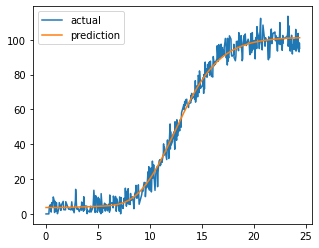

In [82]:
# Graph prediction
plt.plot(poly['speed'], poly['power'], label='actual')
plt.plot(poly['speed'], model.predict(poly['speed']), label='prediction')
plt.legend();

## Sources

https://en.wikipedia.org/wiki/Wind_power (wind description)

https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/#:~:text=In%20order%20to%20check%20missing,null%20values%20in%20a%20series.

https://realpython.com/linear-regression-in-python/

https://www.statsmodels.org/stable/index.html (OLS)

https://www.datarobot.com/blog/ordinary-least-squares-in-python/ (OLS)

https://towardsdatascience.com/polynomial-regression-from-scratch-in-python-1f34a3a5f373(poly regr)

https://statisticsbyjim.com/regression/curve-fitting-linear-nonlinear-regress(poly regr)

https://statisticsbyjim.com/regression/interpret-r-squared-regression/ (R2)

https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 (poly lin regr)

https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/

https://datascienceplus.com/keras-regression-based-neural-networks/ (keras)

